# Homework 5 - Group 1

### Import Libraries

In [1]:
import pandas as pd
from collections import defaultdict
import dask.dataframe as dd
from collections import Counter
import numpy as np


import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.dataframe as dd

import seaborn as sns

import networkx as nx
import matplotlib.pyplot as plt

import random
import os
import json
import operator

## General notes
1. You will notice that one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random. Please, do it before solving any task in the homework.

In [2]:
# create a write json function
def write_json(file_name, content):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    with open(file_name, 'w') as outfile:
        json.dump(content, outfile, sort_keys=True, indent=4)

In [3]:
%%time
data = open("data/wiki-topcats-categories.txt","r+") 

# Create a dictionary with article Ids are keys and Categories are values
articles = defaultdict(list)
for line in data.readlines():
    category, article_list = line.split(';')
    if not (article_list and article_list.strip()):
        continue
    for article in article_list.strip().split(' '):
        articles[article].append(category)
    

Wall time: 4.15 s


In [4]:
%%time
# For each article, Choosing an only one random category that it belongs
for article_Id, categories in articles.items():
    if len(category) != 1:
        index = random.randint(0,len(categories)-1)
        articles[article_Id] = [categories[index]]

Wall time: 3.82 s


In [5]:
%%time
# Building the dictionary with categories are keys and articles are values and each article belongs only one category
categories = defaultdict(list)
for article_Id, category in articles.items():
    categories[category[0]].append(article_Id)

Wall time: 826 ms


In [6]:
# categories

In [7]:
# Save category in the new json file
write_json('data/new_categories.txt', categories)

After these steps, we have the category dataset that each article belongs only one category

## RQ1 
Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them. Then, provide its basic information:

### Import Data

In [8]:
path = 'data/wikigraph_reduced.csv'
dataset = pd.read_csv(path)
dataset = dataset.rename(columns={"Unnamed: 0": "Hyperlinks_Id", "0": "Source", "1": "Target"})
dataset.head()

,Hyperlinks_Id,Source,Target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


### Building the Graph G=(V,E)

In [9]:
class Graph:
    """
        Building a simple graph using an adjacency list
    """
    def __init__(self):
        # Create an empty graph
        self.outgoing = defaultdict(list)
        self.incoming = defaultdict(list)
        self.edges = []
    
    def is_directed(self):
        # return True if the graph is directed
        return self.incoming is not self.outgoing
    
    def vertex_count(self):
        # Count number of vertices in graph
        return len(list(set(self.outgoing.keys()) | set(self.incoming.keys())))

    def vertices(self):
        # Return all vertices in graph
        return list(set(self.outgoing.keys()) | set(self.incoming.keys()))
    
    def edge_count(self):
        # count number of edges in graph
        total = len(self.edges)
        return total if self.is_directed() else total //2
    
    def degree(self, v, outgoing=True):
        # return the in or out degree of a vertex 
        adj = self.outgoing if outgoing else self.incoming
        return len(adj[v])
    
    def incident_edges(self, v, outgoing=True):
        # Return the adjacent vertices of a vertex
        adj = self.outgoing if outgoing else self.incoming
        return adj[v]
    
    def insert_edge(self, u, v):
        # Insert an edge into graph
        self.outgoing[u].append(v)
        self.incoming[v].append(u)
        self.edges.append((u,v))

        

In [10]:
# Declare a Graph
graph = Graph()

In [11]:
%%time
# Insert all edges into the graph
_ = dataset.apply(lambda row: graph.insert_edge(row['Source'], row['Target']), axis = 1)

Wall time: 12 s


<b> Is the graph directed? </b>

In [12]:
graph.is_directed()

True

Yes, The graph is directed

<b> How many articles are we considering? </b>

In [13]:
no_articles = graph.vertex_count()
no_articles

98343

There are 98434 articles that we are considering

<b> How many hyperlinks between pages exist? </b>

In [14]:
no_hyperlinks = graph.edge_count()
no_hyperlinks

483094

There are 483094 hyperlinks betwwen pages exist

<b> Compute the average number of links in an arbitrary page </b>

In [15]:
average_no_links = no_hyperlinks/no_articles
average_no_links

4.912337431235573

The average number of links in a arbitrary page is about 5

<b> What is the graph density? </b>

For directed simple graphs, the maximum possible edges is twice that of undirected graphs to account for the directedness, so the density is:
\begin{align}
D = \frac {E}{V(V-1)}
\end{align}
where E is the number of edges and V is the number of vertices in the graph.

In [16]:
density = no_hyperlinks/(no_articles*(no_articles-1))
density

4.9951571365597335e-05

Based on the small value of density, We do believe that the graph is sparse and not dense

<b> Visualize the nodes' degree distribution </b>

Following the Definition of Degree Distribution on Wikipidia,The degree distribution P(k) of a network is then defined to be the fraction of nodes in the network with degree k. Thus if there are n nodes in total in a network and n_k of them have degree k, we have 


\begin{align}
    P(k) = \frac{n_{k}}{n}
\end{align}

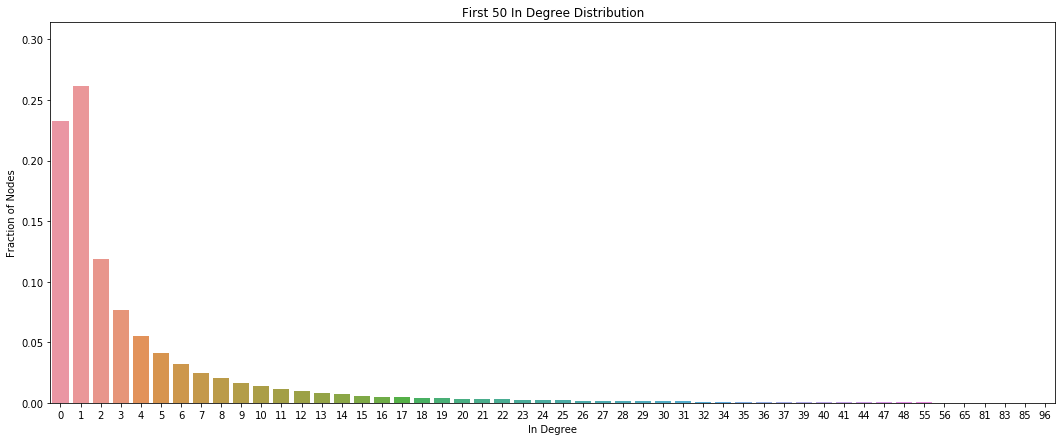

In [17]:
# return in_degree of all vertices in graph
in_degree = [graph.degree(vertex, outgoing=False) for vertex in graph.vertices()]

# Counter the in degree
in_count = Counter(in_degree)

# Calculate the degree distribution of nodes
for key, value in in_count.items():
    in_count[key] = value/no_articles

# Counter form to DataFrame for plot purpose
df = pd.DataFrame.from_dict(in_count, orient='index').reset_index()
df = df.rename(columns={'index':'degree', 0:'degree_distribution'})

# Barplot the degree distribution
plt.figure(figsize=(18,7))
plot = sns.barplot(x='degree',y='degree_distribution',data=df.head(50))
plt.title('First 50 In Degree Distribution')
plt.xlabel('In Degree')
plt.ylabel('Fraction of Nodes')
plt.ylim(0,df['degree_distribution'].max()*1.2);

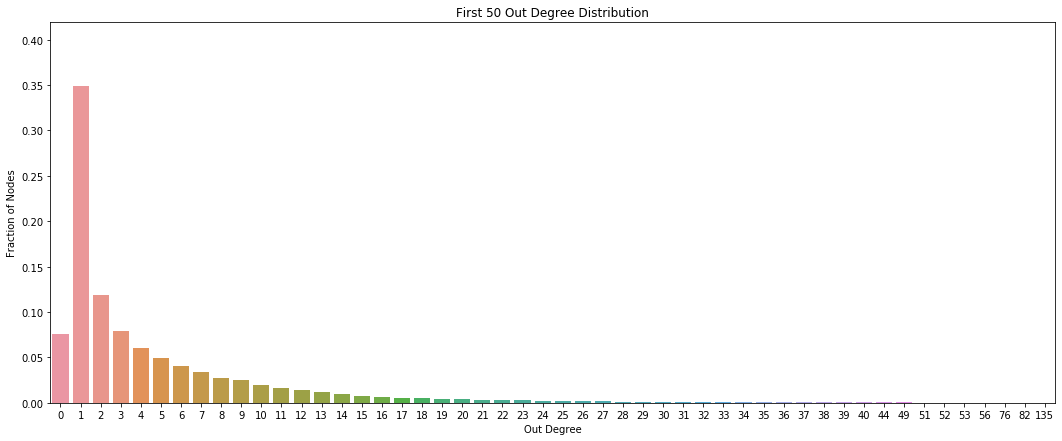

In [18]:
# return out_degree of all vertices in graph
out_degree = [graph.degree(vertex, outgoing=True) for vertex in graph.vertices()]

# Counter the out degree
out_count = Counter(out_degree)

# Calculate the degree distribution of nodes
for key, value in out_count.items():
    out_count[key] = value/no_articles
    
# Counter form to DataFrame for plot purpose
df = pd.DataFrame.from_dict(out_count, orient='index').reset_index()
df = df.rename(columns={'index':'degree', 0:'degree_distribution'})

# Barplot the degree distribution
plt.figure(figsize=(18,7))
plot = sns.barplot(x='degree',y='degree_distribution',data=df.head(50))
plt.title('First 50 Out Degree Distribution')
plt.xlabel('Out Degree')
plt.ylabel('Fraction of Nodes')
plt.ylim(0,df['degree_distribution'].max()*1.2);

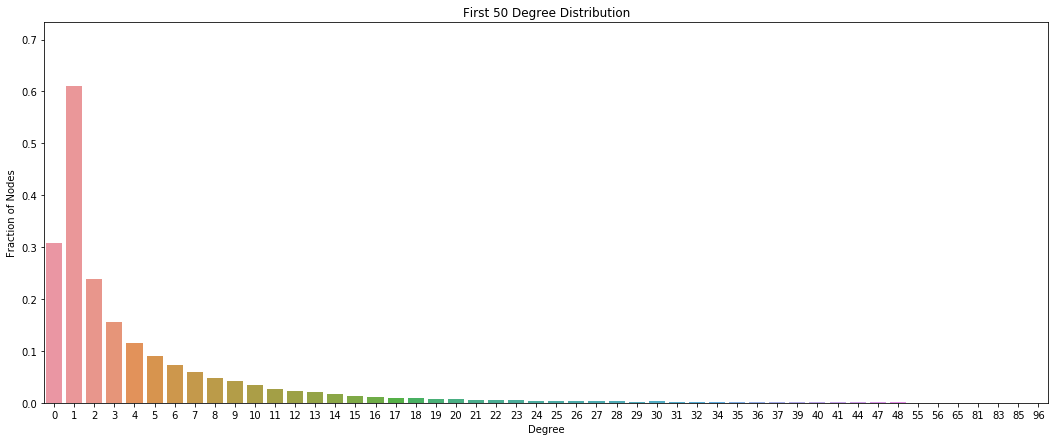

In [19]:
# Degree included both in and out degree
degree = in_degree + out_degree

# Counter the degree
count = Counter(degree)

# Calculate the degree distribution of nodes
for key, value in count.items():
    count[key] = value/no_articles

# Counter form to DataFrame for plot purpose
df = pd.DataFrame.from_dict(count, orient='index').reset_index()
df = df.rename(columns={'index':'degree', 0:'degree_distribution'})

# Barplot the degree distribution
plt.figure(figsize=(18,7))
plot = sns.barplot(x='degree',y='degree_distribution',data=df.head(50))
plt.title('First 50 Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.ylim(0,df['degree_distribution'].max()*1.2);

## RQ2
Define a function that takes in input:
- A page v
- A number of clicks d \
and returns the set of all pages that a user can reach within d clicks.

<b>Initialize the Graph</b>

In [20]:
# Declare a Graph
graph = Graph()
# Insert all edges into the graph
_ = dataset.apply(lambda row: graph.insert_edge(row['Source'], row['Target']), axis = 1)

<b> Build the function </b>

In [21]:
def get_pages_reached(graph, source, depth):
    """
    Build the function return all nodes can reach within number of depth 
    """
    discovered = []
    egdes = []
    level = [source]
    
    # if depth is 0, return source
    if depth == 0:
        return source, egdes
    
    while depth > 0:
        next_level = []
        for vertex in level:
            for adj in graph.incident_edges(vertex):
                if adj not in discovered:
                    edge = (vertex, adj)
                    egdes.append(edge)
                    discovered.append(adj)
                    next_level.append(adj)
        level = next_level
        depth -= 1
    
    return discovered, egdes


In [22]:
# trying with a page 95 with number of click is 2
discovered, egdes = get_pages_reached(graph, 95, 2)

In [23]:
discovered

[1185516, 150451, 1062563, 1178930, 1184017, 1184695, 1761109]

This is all pages that user can reach within d clicks

In [24]:
# return edges
egdes

[(95, 1185516),
 (1185516, 150451),
 (1185516, 1062563),
 (1185516, 1178930),
 (1185516, 1184017),
 (1185516, 1184695),
 (1185516, 1761109)]

D:\Jupyter\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
D:\Jupyter\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


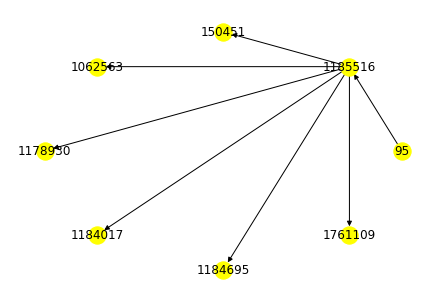

In [25]:
# Vizualization
g = nx.DiGraph()
g.add_edges_from(egdes)
nx.draw_circular(g,node_color = 'yellow', with_labels=1)
plt.draw()
plt.show()

## RQ3
Define a function that takes in input:

- A category C
- A set of pages in C, p = {p1, ..., pn}
and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

### Answer
One way to come up with approximate solutions to this probem is to use heuristics, a techique to find the good choice. When a algorithm uses a heuristic, it no longer needs to exhaustively search every possible path, so it can find the approximate shortest path more quickly. The chosen heuristic for this problem is 'Nearest neighbor'. the algorithm will pick the nearest unvisited article as the next article on the path

<b>Initialize a graph</b>

In [26]:
# Declare a Graph
graph = Graph()
# Insert all edges into the graph
_ = dataset.apply(lambda row: graph.insert_edge(row['Source'], row['Target']), axis = 1)

<b> Load categories </b>

In [27]:
def read_json(file_name):
    with open(file_name) as json_file:
        data_dict = json.load(json_file)
        return data_dict

In [28]:
# Read all categories
categories = read_json('data/new_categories.txt')

<b> Build functions </b>

In [29]:
# Write a function return the in degree list of articles
def in_degree_centrality(graph, articles):
    in_degree = {}
    for article in articles:
        in_degree[article] = graph.degree(int(article), outgoing=False)
    return in_degree

In [30]:
# A function return the distances between the a source article to each article in a category
def get_distances(graph, source, articles, path):
    '''
    Build a function return the distance between the a source article to each article in a category
    - graph: the Graph
    - source: the article source
    - articles: the article targets
    - path: the articles that have reached
    '''
    
    discovered = [] # to save the article is reached
    level = [source]
    distances = {} # to save the distances between source and targets
    count = 1 # count the distance between source and target
    
    while len(articles) > 0:
        next_level = []
        for article in level:
            for adj in graph.incident_edges(article): # return the adjacent articles
                if adj not in discovered:
                    next_level.append(adj)
                    discovered.append(adj)
                    if adj in articles and adj not in path:
                        distances[adj] = count
                        articles.remove(adj)  # when a article reached are removed from articles list. when all articles are reached, articles list will be empty 
        
        # when the next_level is empty and some articles still can not be reached. assign the distance is -1
        if len(next_level) == 0:
            for article in articles:
                if article not in path:
                    distances[article] = -1
            return distances
        
        level = next_level
        count +=1
    
    return distances

In [31]:
def minimum_number_of_clicks(graph, categories, category_name):
    '''
    Returns the minimum number of clicks required to reach all pages in p, 
    starting from the page v which is the in degree centrality
    - graph: the Graph
    - categories: contains category name and articles belong to each category
    - category name: category name input
    '''
    
    articles = list(map(int, categories[category_name]))
    
    # return a in degree of articles
    in_degree = in_degree_centrality(graph, articles)
    
    # if 2 articles have in degree 0. it's impossible to reach all articles
    if Counter(in_degree.values())[0] >=2:
        return '1. Not Possible'
    
    # source is the article with max number of in degree (in degree centrality)
    source = int(max(in_degree.items(), key=operator.itemgetter(1))[0])
    
    # check if the source have no out degree. return 'Not Possilbe'
    out_degree_soure = graph.degree(int(source), outgoing = True)
    if out_degree_soure == 0:
        return '2. Not Possible'
    #else: print('The in degree centrality is ', source)
    
    path = []  # path to save the article reached from articles
    no_clicks = 0  # number of clicks
    
    
    while True: # this will be stopped when all articles are reached or at least one article can't be reached
        
        path.append(source)
        
        # create article target without the article source 
        articles_targets = [article for article in articles if article != source]
        
        # return the distances between source and other articles
        distances = get_distances(graph, source, articles_targets, path)
        
        # if distance = -1, it means there is at least a node which can not be reached
        if -1 in distances.values():
            return '3. Not Possible'
        
        # if lenght of distances = 0, it means all articles are reached
        if len(distances) == 0:
            #print('The shortest path to reach all articles is in order: ', path)
            return no_clicks
        
        # new article source with the shortest distance from the previous article source
        source = min(distances.items(), key=operator.itemgetter(1))[0]
        
        # update number of clicks
        no_clicks += distances[source]
        


<b> Implimentation </b>

In [32]:
# Radom choosing a category
category = random.sample(categories.keys(),1)[0]
minimum_number_of_clicks(graph, categories, category)

'1. Not Possible'

<b> Because the hyperlink file is the reduced file so there are alot of articles in category can not be reached. That is the reason it return  many 'Not Possible'


### MockTest

In [33]:
# Create a graph 
g = Graph()
g.insert_edge(1,5)
g.insert_edge(5,6)
g.insert_edge(6,4)
g.insert_edge(6,7)
g.insert_edge(7,3)
g.insert_edge(3,2)
g.insert_edge(2,1)
g.insert_edge(3,1)
g.insert_edge(4,1)
g.insert_edge(8,7)
# g.insert_edge(5,2)
# g.insert_edge(7,2)

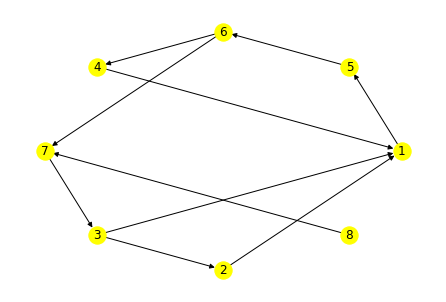

In [34]:
# Plot a new graph to test
g_network = nx.DiGraph()
g_network.add_edges_from(g.edges)
nx.draw_circular(g_network,node_color = 'yellow', with_labels=1)
plt.draw()
plt.show()

In [35]:
categories = {'The Autumn': [1,7,5,2]}

In [36]:
#return minimum number of clicks
min_no_click = minimum_number_of_clicks(g, categories, 'The Autumn')
print('Minimun number of clicks is ', min_no_click)

Minimun number of clicks is  5


## RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

- Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

### Anwser
- We build a subgraph from 2 categories.
- From this subgraph, we randomly choose 2 arbitrary pages and then find all the paths connected 2 pages by applying the DFS algorithm including from u to v and from v to u
- Based on all the paths found, store set of adjcent edges from source and store set of adjacent edges come to target
- Return the minimun set of hyperlinks

<b> Load categories </b>

In [37]:
# Read all categories
categories = read_json('data/new_categories.txt')

<b> Initialize the Graph </b>

In [38]:
graph = Graph()
_ = dataset.apply(lambda row: graph.insert_edge(row['Source'], row['Target']), axis = 1)

<b> Build Subgraph from 2 categories</b>

In [39]:
# Randomly choose 2 categories 
# category1, article_id1 = random.choice(list(categories.items()))
# category2, article_id2 = random.choice(list(categories.items()))

article_id1 = categories['Category:Handball_players_at_the_1988_Summer_Olympics']
article_id2 = categories['Category:American_television_actors']

vertices = list(map(int,article_id1 + article_id2))

subgraph = Graph()
for vertex in vertices:
    for adj in graph.incident_edges(vertex):
        if adj in vertices:
            subgraph.insert_edge(vertex, adj)

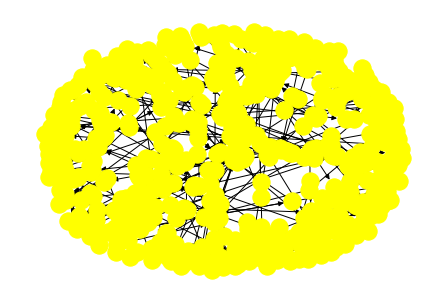

In [40]:
# Vizualize the subgraph
g_network = nx.DiGraph()
g_network.add_edges_from(subgraph.edges)
nx.draw(g_network,node_color = 'yellow', with_labels=0)
plt.draw()
plt.show()

<b> Build Functions </b>

In [41]:
def DFS(graph, source, target, visited, path, no_of_hyperlink): 
  
        # store the current node in visited and path 
        visited.append(source)
        path.append(source) 
  
        # If current vertex is same as destination, save edges from source and target to degree dict
        if source == target:
            print('Path: ', path)
            no_of_hyperlink[path[0]].add((path[0],path[1]))
            no_of_hyperlink[path[-1]].add((path[-2],path[-1]))
        else: 
            #Recur for all the vertices adjacent to this vertex 
            for adj in graph.incident_edges(source): 
                if adj not in visited: 
                    DFS(graph, adj, target, visited, path, no_of_hyperlink) 
                      
        # Remove current vertex from path and visited
        path.pop()
        visited.remove(source)
   

In [42]:
def min_no_of_hyperlinks(graph, source, target):
  
        # declare a empty visited list
        visited =[] 
  
        # Create an list to store paths 
        path = []
        
        #Create a dictionary to contain the adjacent edges from source and to targets
        no_of_hyperlink = defaultdict(set)
        
        # Call the recursive helper function to fill all paths between source and target
        DFS(graph, source, target, visited, path, no_of_hyperlink)
        
        # check if source and target connected
        if len(no_of_hyperlink) == 0:
            return 'Not connected'
        else: # return the minimum set of hyperlinks
            if len(no_of_hyperlink[source]) > len(no_of_hyperlink[target]):
                return no_of_hyperlink[target]
            else:
                return no_of_hyperlink[source]

<b> Implementation  </b>

In [43]:
def QR4(subgraph, page_1, page_2):
    forward = min_no_of_hyperlinks(subgraph, page_1 ,page_2)
    backward = min_no_of_hyperlinks(subgraph, page_2 ,page_1)
    if forward != 'Not connected':
        print('- Minimun set of hyperlinks to disconnect from page 1 to page 2:', forward)
    else: print('- Page 1 to page 2 is', forward)    

    if backward != 'Not connected':
        print('- Minimun set of hyperlinks to disconnect from page 2 to page 1:', backward)
    else: print('- Page 2 to page 1 is', backward)    


In [44]:
#random choose 2 pages from the subgrap
# page_1 = random.choice(subgraph.vertices())
# page_2 = random.choice(subgraph.vertices())
page_1 = 1165218
page_2 = 1062124

QR4(subgraph, page_1, page_2)

Path:  [1165218, 1164970, 1165224, 1062124]
Path:  [1165218, 1165127, 1165225, 1165224, 1062124]
Path:  [1165218, 1165698, 1164970, 1165224, 1062124]
Path:  [1165218, 1165736, 1165127, 1165225, 1165224, 1062124]
- Minimun set of hyperlinks to disconnect from page 1 to page 2: {(1165224, 1062124)}
- Page 2 to page 1 is Not connected


## RQ5
Write a function that, given an arbitrary category $C_0$ as input, returns the list of remaning categories sorted by their distance from $C_0$. In particular, the distance between two categories is defined as

distance($C_0, C_i$) = median(ShortestPath($C_0, C_i$))

where ShortestPath($C_0, C_i$) is the set of shortest paths from each pair of nodes in the two categories.

<b> Load categories </b>

In [45]:
# Read all categories
categories = read_json('data/new_categories.txt')

<b> Initialize a Graph </b>

In [46]:
graph = Graph()
_ = dataset.apply(lambda row: graph.insert_edge(row['Source'], row['Target']), axis = 1)

<b> Build Functions </b>

In [47]:
def shortestpath(graph, source, articles):
    '''
    Build a function return the shortest path from source to all the articles
    Graph: an instance of Graph
    source: a article source
    articles: the list of articles
    '''
    visited = [source]
    level = [source]
    
    distances = dict.fromkeys(articles, -1)
    count = 1
    while True:
        new_level = []
        for article in level:
            for adj in graph.incident_edges(article):
                if adj not in visited:
                    new_level.append(adj)
                    visited.append(adj)
                    if adj in articles:
                        distances[adj] = count
        if len(new_level) == 0:
            break
        level = new_level
        count +=1
    
    if (np.array(list(distances.values())) == -1).all():
        return -1
    else:
        shortest_distance = min([distance for article, distance in distances.items() if distance != -1])
        
    return shortest_distance

In [48]:
def category_distance(graph, categories, input_category):
    '''
    Build a function return list category sorted by distances from input_category
    graph: an instance of Graph
    categories: containing category names as the keys and articles belong to each category as the values
    input_category: the category name
    '''
    
    cate_distances = {}
    
    for category, articles in categories.items():
        shortest_path = {}
        articles = [int(article) for article in articles if article in graph.vertices()]
        if category != input_category:
            for source in categories[input_category]:
                if source in graph.vertices():
                    shortest_distance = shortestpath(graph, int(source), articles) # return shortest distance from source to articles
                    
                    if shortest_distance == -1: 
                         continue
                    else:
                        shortest_path[source] = shortest_distance
            
            if len(shortest_path) == 0:
                continue
            else:
                median = np.median([shortest for source, shortest in shortest_path.items()])
                cate_distances[category] = median
    if len(cate_distances) == 0:
        return 'Input Category have no connection with the other categories'
    else:
        return dict(sorted(cate_distances.items(), key=lambda item: item[1]))

<b> Implementation </b>

In [49]:
# Random to choose a category
# input_category = random.sample(categories.keys(),1)[0]

input_category = 'Category:12th-century_English_people'
# category_distance(graph, categories, input_category)

Comments: Because we have a huge number of nodes in graph, so to find the shortest path from a source to a list of articles take a lot of time so we created a Mocktest to run the functions

### MockTest

In [50]:
# Create a graph 
g = Graph()
g.insert_edge(1,5)
g.insert_edge(5,6)
g.insert_edge(6,4)
g.insert_edge(6,7)
g.insert_edge(7,3)
g.insert_edge(3,2)
g.insert_edge(2,1)
g.insert_edge(3,1)
g.insert_edge(4,1)
g.insert_edge(8,7)
g.insert_edge(8,9)

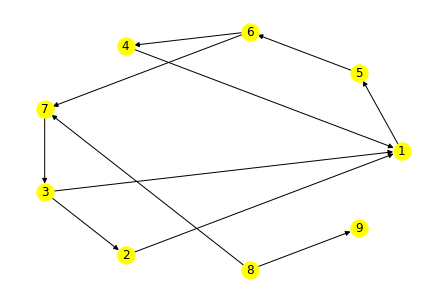

In [51]:
# Plot a new graph to test
g_network = nx.DiGraph()
g_network.add_edges_from(g.edges)
nx.draw_circular(g_network,node_color = 'yellow', with_labels=1)
plt.draw()
plt.show()

In [52]:
category= {'Category:Living_people': [2,1, 3], 'Category:English-language_films':[5,6], 'Category:American_films':[1,8]}

In [53]:
input_category = 'Category:Living_people'
category_distance(g, category, input_category)

{'Category:American_films': 1.0, 'Category:English-language_films': 2.0}

## RQ6
Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

### Answer
- Model of the network of categories by building a directed graph with each node is a category and weight of each edge is number of connection(edges) from a category to an another category
- When we have a weighted directed graph of categories, we apply the PageRank Algorithm below:


\begin{align}
    PR(u) = \sum_{ v \in B_u} \frac{PR(v)}{L(v)}
\end{align}

Where:
- PR(u) is pagerank value for a page u
- v is a page contained in set $B_u$ which is a set containing all pages direct to page u
- L(v) is a total number of oubound links from page v

<b> Load categories </b>

In [54]:
# Read all categories
categories = read_json('data/new_categories.txt')

<b> Initialize a graph </b>

In [55]:
graph = Graph()
_ = dataset.apply(lambda row: graph.insert_edge(row['Source'], row['Target']), axis = 1)

### Building a weighted directed Graph with each node as a category

In [56]:
# Create an articles dictionary with article Id as key and category Id as values
articles = dict.fromkeys(graph.vertices(), 0)
category_ids = {} # contain category Id as key and category name as values coressponding
count = 0
for category_name, article_ids in categories.items():
    article_ids = list(map(int, article_ids))
    category_ids[count] = category_name
    for article_id in article_ids:
        if article_id in articles.keys():
            articles[article_id] = count
    count += 1

In [57]:
model = nx.DiGraph()
# add nodes as the categories in to graph
model.add_nodes_from(category_ids.keys())

In [58]:
# add edges into graph with weights which is number of ouboud links for the category source to category target
category_source = 0
for category_name, article_ids in categories.items():
    out_categories = [] 
    article_ids = list(map(int, article_ids))
    
    for article_id in article_ids:
        out_degree = graph.incident_edges(article_id)
        out_categories += [articles[a_id] for a_id in out_degree]
        
    if len(out_categories) != 0:
        for category_target, weight in Counter(out_categories).items():
            model.add_weighted_edges_from([(category_source, category_target, weight)])
    category_source += 1

In [59]:
# model.edges().data('weight')

### PageRank Algorithm

In [60]:
def PageRank(model, iters = 10):
    
    # initialize the weighted rank for each category
    old_rank = dict.fromkeys(model.nodes(), 1/model.number_of_nodes())
    
    for i in range(iters):

        page_rank = old_rank.copy()
        
        for page in model.nodes():
            predecessors =  list(model.predecessors(page))  # return set of pages(category) direct to page
            if len(predecessors) == 0:
                continue
            else:
                weighted = [ old_rank[i] for i in predecessors ] # return weighted rank of pages directing to page
                out_degree = [ model.out_degree(i, weight='weight')  for i in predecessors ] # return number of oubound links


                new_rank = sum( np.array(weighted) / np.array(out_degree))  # calculate the new weight rank for page

                page_rank[page] = new_rank  # update new weighted rank
                
        old_rank = page_rank.copy()
    
    return old_rank

### Implementation

In [61]:
categoryrank = PageRank(model,iters=10)
sorted_categoryrank = dict(sorted(categoryrank.items(), key=lambda item: item[1], reverse=True ))


In [62]:
print('------Top 20 Categories Rank-------')
count = 1
for category_id, rank in sorted_categoryrank.items():
    print(category_ids[category_id], rank)
    if count == 20:
        break

Category:Living_people 0.002230519753189546
Category:Harvard_University_alumni 0.0013064824152741654
Category:18th-century_actors 0.0006337500720170538
Category:Year_of_death_missing 0.0006221592410960053
Category:Association_football_midfielders 0.0006152329764948485
Category:Year_of_birth_missing 0.0006108802827956776
Category:Place_of_birth_missing_(living_people) 0.0005553577582802481
Category:English-language_films 0.0004963415492145869
Category:Infectious_disease_deaths_in_California 0.0004538750591925096
Category:The_Football_League_players 0.00044954131715011923
Category:American_television_actors 0.00042835913317796476
Category:American_film_actors 0.000414482399420498
Category:Harvard_University_faculty 0.0003972525903496016
Category:Association_football_forwards 0.00034873814923744843
Category:English_footballers 0.00032036513967488887
Category:American_people_of_Irish_descent 0.0003027593774217399
Category:Alumni_of_Sciences_Po 0.00026351970046139037
Category:American_films

Category:African_American_journalists 5.761364291064124e-05
Category:African_American_judges 5.761364291064124e-05
Category:African_American_mayors 5.761364291064124e-05
Category:African_American_members_of_the_United_States_House_of_Representatives 5.761364291064124e-05
Category:African_American_musical_groups 5.761364291064124e-05
Category:African_American_players_of_American_football 5.761364291064124e-05
Category:African_American_players_of_Canadian_football 5.761364291064124e-05
Category:African_American_poets 5.761364291064124e-05
Category:African_American_politicians 5.761364291064124e-05
Category:African_American_rock_musicians 5.761364291064124e-05
Category:African_American_track_and_field_athletes 5.761364291064124e-05
Category:African_American_women_in_politics 5.761364291064124e-05
Category:African_National_Congress_politicians 5.761364291064124e-05
Category:African_mythology 5.761364291064124e-05
Category:Afrikaner_people 5.761364291064124e-05
Category:Aftermath_of_World_W

Category:American_women's_rights_activists 5.761364291064124e-05
Category:American_women_artists 5.761364291064124e-05
Category:American_women_mayors 5.761364291064124e-05
Category:American_writers_of_German_descent 5.761364291064124e-05
Category:American_young_adult_novels 5.761364291064124e-05
Category:Amhara_Region 5.761364291064124e-05
Category:Amides 5.761364291064124e-05
Category:Amiens_SC_players 5.761364291064124e-05
Category:Amiga 5.761364291064124e-05
Category:Amiga_games 5.761364291064124e-05
Category:Amines 5.761364291064124e-05
Category:Amino_acids 5.761364291064124e-05
Category:Ammonites 5.761364291064124e-05
Category:Ammunition 5.761364291064124e-05
Category:Amphetamines 5.761364291064124e-05
Category:Amphibians_of_Colombia 5.761364291064124e-05
Category:Amphibians_of_Ecuador 5.761364291064124e-05
Category:Amphibians_of_Papua_New_Guinea 5.761364291064124e-05
Category:Amphibians_of_Peru 5.761364291064124e-05
Category:Amphibians_of_Queensland 5.761364291064124e-05
Category

Category:Baloch_tribes 5.761364291064124e-05
Category:Baltic_Germans 5.761364291064124e-05
Category:BaltimoreWashington_metropolitan_area 5.761364291064124e-05
Category:Baltimore_City_College_alumni 5.761364291064124e-05
Category:Baltimore_Orioles_(AA)_players 5.761364291064124e-05
Category:Baltimore_Ravens_players 5.761364291064124e-05
Category:Baltimore_Skipjacks_players 5.761364291064124e-05
Category:Bam_Province 5.761364291064124e-05
Category:Bandai_Entertainment_anime_titles 5.761364291064124e-05
Category:Bangladesh_Liberation_War 5.761364291064124e-05
Category:Bangladeshi_cricketers 5.761364291064124e-05
Category:Bangladeshi_writers 5.761364291064124e-05
Category:Banking 5.761364291064124e-05
Category:Banking_terms_and_equipment 5.761364291064124e-05
Category:Banksia_ser._Dryandra 5.761364291064124e-05
Category:Banksia_taxa_by_scientific_name 5.761364291064124e-05
Category:Bannered_and_suffixed_U.S._Highways 5.761364291064124e-05
Category:Bantamweight_boxers 5.761364291064124e-05

Category:Buffalo_Bills_(AFL)_players 5.761364291064124e-05
Category:Buffalo_Bills_players 5.761364291064124e-05
Category:Buffalo_Bisons_(AHL)_players 5.761364291064124e-05
Category:Buffalo_Sabres_draft_picks 5.761364291064124e-05
Category:Buffalo_Sabres_players 5.761364291064124e-05
Category:Buffy_the_Vampire_Slayer_episodes 5.761364291064124e-05
Category:Bufo 5.761364291064124e-05
Category:Building_engineering 5.761364291064124e-05
Category:Building_materials 5.761364291064124e-05
Category:Buildings_and_structures_in_Baltimore,_Maryland 5.761364291064124e-05
Category:Buildings_and_structures_in_Birmingham,_West_Midlands 5.761364291064124e-05
Category:Buildings_and_structures_in_Boston,_Massachusetts 5.761364291064124e-05
Category:Buildings_and_structures_in_Brisbane 5.761364291064124e-05
Category:Buildings_and_structures_in_Bristol 5.761364291064124e-05
Category:Buildings_and_structures_in_Brooklyn 5.761364291064124e-05
Category:Buildings_and_structures_in_Buenos_Aires 5.7613642910641

Category:Circuses 5.761364291064124e-05
Category:Cis-regulatory_RNA_elements 5.761364291064124e-05
Category:Cistercians 5.761364291064124e-05
Category:Citadel_Broadcasting_radio_stations 5.761364291064124e-05
Category:Cities_and_towns_built_in_the_Soviet_Union 5.761364291064124e-05
Category:Cities_and_towns_in_Abruzzo 5.761364291064124e-05
Category:Cities_and_towns_in_Apulia 5.761364291064124e-05
Category:Cities_and_towns_in_Basilicata 5.761364291064124e-05
Category:Cities_and_towns_in_Burgenland 5.761364291064124e-05
Category:Cities_and_towns_in_Calabria 5.761364291064124e-05
Category:Cities_and_towns_in_Campania 5.761364291064124e-05
Category:Cities_and_towns_in_Carinthia 5.761364291064124e-05
Category:Cities_and_towns_in_Croatia 5.761364291064124e-05
Category:Cities_and_towns_in_Emilia-Romagna 5.761364291064124e-05
Category:Cities_and_towns_in_Finland 5.761364291064124e-05
Category:Cities_and_towns_in_Friuli-Venezia_Giulia 5.761364291064124e-05
Category:Cities_and_towns_in_Greater_P

Category:Cooling_technology 5.761364291064124e-05
Category:Cooper_Union_alumni 5.761364291064124e-05
Category:Cooperative_video_games 5.761364291064124e-05
Category:Copper_minerals 5.761364291064124e-05
Category:Copyright_law 5.761364291064124e-05
Category:Coritiba_Foot_Ball_Club_players 5.761364291064124e-05
Category:Cork_Gaelic_footballers 5.761364291064124e-05
Category:Cornish_culture 5.761364291064124e-05
Category:Coronation_Street_characters 5.761364291064124e-05
Category:Corporate_finance 5.761364291064124e-05
Category:Corynebacterineae 5.761364291064124e-05
Category:Cosmopterix 5.761364291064124e-05
Category:Costa_Rica_international_footballers 5.761364291064124e-05
Category:Costellariidae 5.761364291064124e-05
Category:Cotswold_(district) 5.761364291064124e-05
Category:Council_elections_in_Greater_London 5.761364291064124e-05
Category:Council_of_Independent_Colleges 5.761364291064124e-05
Category:Counter-terrorism 5.761364291064124e-05
Category:Counties_of_Iran 5.76136429106412

Category:Economic_historians 5.761364291064124e-05
Category:Economic_ideologies 5.761364291064124e-05
Category:Economic_problems 5.761364291064124e-05
Category:Economic_theories 5.761364291064124e-05
Category:Economics 5.761364291064124e-05
Category:Economics_books 5.761364291064124e-05
Category:Economics_journals 5.761364291064124e-05
Category:Economics_lists_by_country 5.761364291064124e-05
Category:Economics_terminology 5.761364291064124e-05
Category:Ecuadorian_footballers 5.761364291064124e-05
Category:Ecuadorian_people_of_Black_African_descent 5.761364291064124e-05
Category:Ed_Block_Courage_Award_recipients 5.761364291064124e-05
Category:Edible_fish 5.761364291064124e-05
Category:Edible_fungi 5.761364291064124e-05
Category:Edible_molluscs 5.761364291064124e-05
Category:Edible_nuts_and_seeds 5.761364291064124e-05
Category:Edmonton_Eskimos_players 5.761364291064124e-05
Category:Edmonton_Oilers_(WHA)_players 5.761364291064124e-05
Category:Edmonton_Oilers_draft_picks 5.761364291064124

Category:Fauna_of_Tanzania 5.761364291064124e-05
Category:Fauna_of_the_Amazon 5.761364291064124e-05
Category:Fauna_of_the_California_chaparral_and_woodlands 5.761364291064124e-05
Category:Fauna_of_the_United_States 5.761364291064124e-05
Category:Featherstone_Rovers_players 5.761364291064124e-05
Category:Featherweight_boxers 5.761364291064124e-05
Category:Featherweight_mixed_martial_artists 5.761364291064124e-05
Category:Fed_Cup_teams 5.761364291064124e-05
Category:Federal_architecture_in_Connecticut 5.761364291064124e-05
Category:Federal_architecture_in_Maryland 5.761364291064124e-05
Category:Federal_architecture_in_New_York 5.761364291064124e-05
Category:Federal_courthouses_of_the_United_States 5.761364291064124e-05
Category:Federal_ministers_of_Nigeria 5.761364291064124e-05
Category:Federal_political_parties_in_Canada 5.761364291064124e-05
Category:Federally_recognized_tribes_in_the_United_States 5.761364291064124e-05
Category:Fellow_Members_of_the_IEEE 5.761364291064124e-05
Category

Category:Fossil_taxa_described_in_2010 5.761364291064124e-05
Category:Fossil_taxa_described_in_2011 5.761364291064124e-05
Category:Foundations_based_in_the_United_States 5.761364291064124e-05
Category:Founders_of_English_schools_and_colleges 5.761364291064124e-05
Category:Founders_of_Roman_Catholic_religious_communities 5.761364291064124e-05
Category:Founders_of_religions 5.761364291064124e-05
Category:Fourier_analysis 5.761364291064124e-05
Category:Fox_Kids 5.761364291064124e-05
Category:Fox_network_affiliates 5.761364291064124e-05
Category:Fox_network_shows 5.761364291064124e-05
Category:Fractals 5.761364291064124e-05
Category:France_international_rugby_union_players 5.761364291064124e-05
Category:Franchises 5.761364291064124e-05
Category:Frank_Lloyd_Wright_buildings 5.761364291064124e-05
Category:Frank_Sinatra_songs 5.761364291064124e-05
Category:Frankfurt_Galaxy_players 5.761364291064124e-05
Category:Frankish_people 5.761364291064124e-05
Category:Franks 5.761364291064124e-05
Catego

Category:Handball_players_at_the_1972_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_1976_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_1980_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_1984_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_1988_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_1992_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_1996_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_2000_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_2004_Summer_Olympics 5.761364291064124e-05
Category:Handball_players_at_the_2008_Summer_Olympics 5.761364291064124e-05
Category:Handbooks_and_manuals 5.761364291064124e-05
Category:Hanna-Barbera_and_Cartoon_Network_Studios_series_and_characters 5.761364291064124e-05
Category:Haplochromis 5.761364291064124e-05
Category:Hapoel_Be'er_Sheva_F.C._players 5.76136

Category:Indian_lawyers 5.761364291064124e-05
Category:Indian_magazines 5.761364291064124e-05
Category:Indian_mathematicians 5.761364291064124e-05
Category:Indian_monarchs 5.761364291064124e-05
Category:Indian_musicians 5.761364291064124e-05
Category:Indian_novelists 5.761364291064124e-05
Category:Indian_novels 5.761364291064124e-05
Category:Indian_painters 5.761364291064124e-05
Category:Indian_people 5.761364291064124e-05
Category:Indian_philosophers 5.761364291064124e-05
Category:Indian_poets 5.761364291064124e-05
Category:Indian_reality_television_series 5.761364291064124e-05
Category:Indian_religious_leaders 5.761364291064124e-05
Category:Indian_revolutionaries 5.761364291064124e-05
Category:Indian_songs 5.761364291064124e-05
Category:Indian_stage_actors 5.761364291064124e-05
Category:Indian_television_presenters 5.761364291064124e-05
Category:Indian_television_series 5.761364291064124e-05
Category:Indian_television_soap_operas 5.761364291064124e-05
Category:Indian_women_in_politic

Category:Languages_of_Indonesia 5.761364291064124e-05
Category:Languages_of_Nigeria 5.761364291064124e-05
Category:Languages_of_Papua_New_Guinea 5.761364291064124e-05
Category:Languages_of_Russia 5.761364291064124e-05
Category:Languages_of_the_United_States 5.761364291064124e-05
Category:Larentiinae 5.761364291064124e-05
Category:Las_Vegas_Locomotives_players 5.761364291064124e-05
Category:Lasiocampidae 5.761364291064124e-05
Category:Late-2000s_financial_crisis 5.761364291064124e-05
Category:Late_Antiquity 5.761364291064124e-05
Category:Latin_Americanists 5.761364291064124e-05
Category:Latin_Grammy_Award_winners 5.761364291064124e-05
Category:Latin_legal_terms 5.761364291064124e-05
Category:Latin_music 5.761364291064124e-05
Category:Latin_words_and_phrases 5.761364291064124e-05
Category:Latin_words_found_in_species_names 5.761364291064124e-05
Category:Latter_Day_Saint_terms 5.761364291064124e-05
Category:Latvia_international_footballers 5.761364291064124e-05
Category:Latvian_footballer

Category:Members_of_the_15th_Dil 5.761364291064124e-05
Category:Members_of_the_17th_Dil 5.761364291064124e-05
Category:Members_of_the_18th_Dil 5.761364291064124e-05
Category:Members_of_the_19th_Dil 5.761364291064124e-05
Category:Members_of_the_20th_Dil 5.761364291064124e-05
Category:Members_of_the_21st_Dil 5.761364291064124e-05
Category:Members_of_the_22nd_Dil 5.761364291064124e-05
Category:Members_of_the_23rd_Dil 5.761364291064124e-05
Category:Members_of_the_24th_Dil 5.761364291064124e-05
Category:Members_of_the_25th_Dil 5.761364291064124e-05
Category:Members_of_the_26th_Dil 5.761364291064124e-05
Category:Members_of_the_27th_Dil 5.761364291064124e-05
Category:Members_of_the_28th_Dil 5.761364291064124e-05
Category:Members_of_the_29th_Dil 5.761364291064124e-05
Category:Members_of_the_2nd_Dil 5.761364291064124e-05
Category:Members_of_the_30th_Dil 5.761364291064124e-05
Category:Members_of_the_31st_Dil 5.761364291064124e-05
Category:Members_of_the_3rd_Dil 5.761364291064124e-05
Category:Mem

Category:Municipalities_in_Mlaga 5.761364291064124e-05
Category:Municipalities_in_Navarre 5.761364291064124e-05
Category:Municipalities_in_Palencia 5.761364291064124e-05
Category:Municipalities_in_Quebec 5.761364291064124e-05
Category:Municipalities_in_Rhineland-Palatinate 5.761364291064124e-05
Category:Municipalities_in_Salamanca 5.761364291064124e-05
Category:Municipalities_in_Schleswig-Holstein 5.761364291064124e-05
Category:Municipalities_in_Segovia 5.761364291064124e-05
Category:Municipalities_in_Seville 5.761364291064124e-05
Category:Municipalities_in_Soria 5.761364291064124e-05
Category:Municipalities_in_Tarragona 5.761364291064124e-05
Category:Municipalities_in_Teruel 5.761364291064124e-05
Category:Municipalities_in_Thuringia 5.761364291064124e-05
Category:Municipalities_in_Toledo_province 5.761364291064124e-05
Category:Municipalities_in_Valencia 5.761364291064124e-05
Category:Municipalities_in_Valladolid 5.761364291064124e-05
Category:Municipalities_in_Zamora 5.761364291064124

Category:Norwegian_historians 5.761364291064124e-05
Category:Norwegian_ice_hockey_players 5.761364291064124e-05
Category:Norwegian_journalists 5.761364291064124e-05
Category:Norwegian_jurists 5.761364291064124e-05
Category:Norwegian_lawyers 5.761364291064124e-05
Category:Norwegian_male_singers 5.761364291064124e-05
Category:Norwegian_military_personnel 5.761364291064124e-05
Category:Norwegian_musical_groups 5.761364291064124e-05
Category:Norwegian_newspaper_editors 5.761364291064124e-05
Category:Norwegian_non-fiction_writers 5.761364291064124e-05
Category:Norwegian_novelists 5.761364291064124e-05
Category:Norwegian_orienteers 5.761364291064124e-05
Category:Norwegian_painters 5.761364291064124e-05
Category:Norwegian_people_of_World_War_II 5.761364291064124e-05
Category:Norwegian_poets 5.761364291064124e-05
Category:Norwegian_politicians 5.761364291064124e-05
Category:Norwegian_resistance_members 5.761364291064124e-05
Category:Norwegian_ski_jumpers 5.761364291064124e-05
Category:Norwegia

Category:Pelhimov_District 5.761364291064124e-05
Category:Pennell_Coast 5.761364291064124e-05
Category:Pennsylvania-related_lists 5.761364291064124e-05
Category:Pennsylvania_Democratic-Republicans 5.761364291064124e-05
Category:Pennsylvania_Democrats 5.761364291064124e-05
Category:Pennsylvania_House_of_Representatives_Districts 5.761364291064124e-05
Category:Pennsylvania_Republicans 5.761364291064124e-05
Category:Pennsylvania_State_Senators 5.761364291064124e-05
Category:Pennsylvania_State_University 5.761364291064124e-05
Category:Pennsylvania_lawyers 5.761364291064124e-05
Category:Pennsylvania_state_court_judges 5.761364291064124e-05
Category:Pennsylvania_state_parks 5.761364291064124e-05
Category:Pennsylvania_township_disambiguation_pages 5.761364291064124e-05
Category:Penrith_Panthers_players 5.761364291064124e-05
Category:People's_Artists_of_Russia 5.761364291064124e-05
Category:People's_Artists_of_the_USSR 5.761364291064124e-05
Category:People's_Democratic_Party_(Nigeria)_politici

Category:Pli_words_and_phrases 5.761364291064124e-05
Category:Pliocene_mammals 5.761364291064124e-05
Category:Plumbing 5.761364291064124e-05
Category:Plus_Beaux_Villages_de_France 5.761364291064124e-05
Category:Plusiinae 5.761364291064124e-05
Category:Plymouth-built_ships 5.761364291064124e-05
Category:Poaceae 5.761364291064124e-05
Category:Poaceae_genera 5.761364291064124e-05
Category:Podocarpaceae 5.761364291064124e-05
Category:Poetic_rhythm 5.761364291064124e-05
Category:Poetry_anthologies 5.761364291064124e-05
Category:Poetry_awards 5.761364291064124e-05
Category:Poetry_collections 5.761364291064124e-05
Category:Point-and-click_adventure_games 5.761364291064124e-05
Category:Point_guards 5.761364291064124e-05
Category:Poisonous_plants 5.761364291064124e-05
Category:Poland__Soviet_Union_relations 5.761364291064124e-05
Category:Poland_international_footballers 5.761364291064124e-05
Category:Polemoniaceae 5.761364291064124e-05
Category:Police_procedural_television_series 5.761364291064

Category:Radio_stations_in_Alabama 5.761364291064124e-05
Category:Radio_stations_in_Arizona 5.761364291064124e-05
Category:Radio_stations_in_Arkansas 5.761364291064124e-05
Category:Radio_stations_in_California 5.761364291064124e-05
Category:Radio_stations_in_Colorado 5.761364291064124e-05
Category:Radio_stations_in_Florida 5.761364291064124e-05
Category:Radio_stations_in_Georgia_(U.S._state) 5.761364291064124e-05
Category:Radio_stations_in_Idaho 5.761364291064124e-05
Category:Radio_stations_in_Illinois 5.761364291064124e-05
Category:Radio_stations_in_Indiana 5.761364291064124e-05
Category:Radio_stations_in_Iowa 5.761364291064124e-05
Category:Radio_stations_in_Kansas 5.761364291064124e-05
Category:Radio_stations_in_Kentucky 5.761364291064124e-05
Category:Radio_stations_in_Louisiana 5.761364291064124e-05
Category:Radio_stations_in_Maine 5.761364291064124e-05
Category:Radio_stations_in_Massachusetts 5.761364291064124e-05
Category:Radio_stations_in_Michigan 5.761364291064124e-05
Category:R

Category:Scarabaeidae 5.761364291064124e-05
Category:Scheduled_Ancient_Monuments_in_Scotland 5.761364291064124e-05
Category:Scheduled_Ancient_Monuments_in_Somerset 5.761364291064124e-05
Category:Scheduled_sports_events 5.761364291064124e-05
Category:Schinia 5.761364291064124e-05
Category:Schistura 5.761364291064124e-05
Category:Scholastic_philosophers 5.761364291064124e-05
Category:School_anime_and_manga 5.761364291064124e-05
Category:School_districts_in_Georgia_(U.S._state) 5.761364291064124e-05
Category:School_districts_in_Illinois 5.761364291064124e-05
Category:School_districts_in_Michigan 5.761364291064124e-05
Category:School_districts_in_Mississippi 5.761364291064124e-05
Category:School_districts_in_New_York 5.761364291064124e-05
Category:School_districts_in_Ohio 5.761364291064124e-05
Category:School_districts_in_Texas 5.761364291064124e-05
Category:School_of_the_Art_Institute_of_Chicago_alumni 5.761364291064124e-05
Category:School_principals_and_headteachers 5.761364291064124e-05

Category:Spanish_novelists 5.761364291064124e-05
Category:Spanish_painters 5.761364291064124e-05
Category:Spanish_people_of_the_Spanish_Civil_War 5.761364291064124e-05
Category:Spanish_poets 5.761364291064124e-05
Category:Spanish_saints 5.761364291064124e-05
Category:Spanish_singers 5.761364291064124e-05
Category:Spanish_writers 5.761364291064124e-05
Category:Sparta_Rotterdam_players 5.761364291064124e-05
Category:Speakers_of_the_New_York_State_Assembly 5.761364291064124e-05
Category:Special_Operations_Executive_personnel 5.761364291064124e-05
Category:Special_functions 5.761364291064124e-05
Category:Specific_letter-diacritic_combinations 5.761364291064124e-05
Category:Spectroscopic_binaries 5.761364291064124e-05
Category:Spectroscopy 5.761364291064124e-05
Category:Speed_skaters_at_the_2006_Winter_Olympics 5.761364291064124e-05
Category:Spellemannprisen_winners 5.761364291064124e-05
Category:Sphingini 5.761364291064124e-05
Category:Spices 5.761364291064124e-05
Category:Spilomelinae 5.7

Category:Towns_in_Texas 5.761364291064124e-05
Category:Towns_in_Turkey 5.761364291064124e-05
Category:Towns_in_Ukraine 5.761364291064124e-05
Category:Towns_in_Vermont 5.761364291064124e-05
Category:Towns_in_Victoria_(Australia) 5.761364291064124e-05
Category:Towns_in_Virginia 5.761364291064124e-05
Category:Towns_in_West_Virginia 5.761364291064124e-05
Category:Towns_in_Western_Australia 5.761364291064124e-05
Category:Towns_in_the_Riverina 5.761364291064124e-05
Category:Township-level_divisions_of_Hebei 5.761364291064124e-05
Category:Township_capitals_of_Burma 5.761364291064124e-05
Category:Township_municipalities_in_Ontario 5.761364291064124e-05
Category:Toxicology 5.761364291064124e-05
Category:Toy_brands 5.761364291064124e-05
Category:Toy_cars_and_trucks 5.761364291064124e-05
Category:Toy_companies_of_the_United_States 5.761364291064124e-05
Category:Toyota_concept_vehicles 5.761364291064124e-05
Category:Toyota_vehicles 5.761364291064124e-05
Category:Toys_of_the_1980s 5.761364291064124

Category:Video_games_based_on_anime_and_manga 5.761364291064124e-05
Category:Video_games_based_on_films 5.761364291064124e-05
Category:Video_games_based_on_novels 5.761364291064124e-05
Category:Video_games_developed_in_Australia 5.761364291064124e-05
Category:Video_games_developed_in_Canada 5.761364291064124e-05
Category:Video_games_developed_in_France 5.761364291064124e-05
Category:Video_games_developed_in_Germany 5.761364291064124e-05
Category:Video_games_developed_in_Japan 5.761364291064124e-05
Category:Video_games_developed_in_South_Korea 5.761364291064124e-05
Category:Video_games_developed_in_the_United_Kingdom 5.761364291064124e-05
Category:Video_games_developed_in_the_United_States 5.761364291064124e-05
Category:Video_games_featuring_anthropomorphic_characters 5.761364291064124e-05
Category:Video_games_set_in_Japan 5.761364291064124e-05
Category:Video_games_set_in_New_York_City 5.761364291064124e-05
Category:Video_games_set_in_the_United_States 5.761364291064124e-05
Category:Vid

Category:Wills_and_trusts 5.761364291064124e-05
Category:Wimbledon_Championships_by_year 5.761364291064124e-05
Category:Wimbledon_champions 5.761364291064124e-05
Category:Wimbledon_champions_(pre-Open_Era) 5.761364291064124e-05
Category:Windows-only_freeware 5.761364291064124e-05
Category:Windows-only_software 5.761364291064124e-05
Category:Windows_administration 5.761364291064124e-05
Category:Windows_components 5.761364291064124e-05
Category:Windows_games 5.761364291064124e-05
Category:Windows_software 5.761364291064124e-05
Category:Windsor_Spitfires_alumni 5.761364291064124e-05
Category:Wine_regions_of_Spain 5.761364291064124e-05
Category:Winners_of_LPGA_major_golf_championships 5.761364291064124e-05
Category:Winners_of_the_United_States_Championship_for_amateur_boxers 5.761364291064124e-05
Category:Winnipeg_Blue_Bombers_players 5.761364291064124e-05
Category:Winnipeg_Jets_(197996)_players 5.761364291064124e-05
Category:Wireless_networking 5.761364291064124e-05
Category:Wisconsin_Bad

Category:Films_set_in_the_1970s 1.9544925921664917e-05
Category:Boston_Red_Sox_players 1.9539712002729955e-05
Category:Cancer_deaths_in_England 1.953068512744638e-05
Category:1991_films 1.9420486414633043e-05
Category:Black_British_sportspeople 1.9383176489379847e-05
Category:2004_Copa_Amrica_players 1.935386596466574e-05
Category:Expatriate_footballers_in_Uruguay 1.930404005812096e-05
Category:Cardiff_City_F.C._players 1.9294776224920046e-05
Category:People_from_Gothenburg 1.9258652372888296e-05
Category:Johns_Hopkins_University_alumni 1.925129143566888e-05
Category:19th-century_baseball_players 1.9251263588376765e-05
Category:Films_shot_digitally 1.9244065078626428e-05
Category:Cyprus_international_footballers 1.9204547636880415e-05
Category:FC_Kryvbas_Kryvyi_Rih_players 1.9204547636880415e-05
Category:Illinois_Democrats 1.9204547636880415e-05
Category:Films_shot_anamorphically 1.919462626746485e-05
Category:Rotherham_United_F.C._players 1.910370966404015e-05
Category:Udinese_Calcio_

Category:British_MPs_17961800 6.6957877786362715e-06
Category:2007_CONCACAF_Gold_Cup_players 6.691872254137932e-06
Category:English-language_albums 6.687522786293289e-06
Category:Baronets_in_the_Baronetage_of_the_United_Kingdom 6.680891549771831e-06
Category:Elche_CF_players 6.674501562706704e-06
Category:Tudor_bishops 6.67222503435669e-06
Category:Films_about_religion 6.666899426843258e-06
Category:People_from_Florida 6.663778380662492e-06
Category:Olympic_track_and_field_athletes_of_the_United_States 6.66111104493715e-06
Category:Newport_County_A.F.C._players 6.6609614676203105e-06
Category:1950s_science_fiction_films 6.659749654679746e-06
Category:Wrexham_F.C._players 6.643450209577403e-06
Category:American_short_story_writers 6.636777493536797e-06
Category:People_from_Vienna 6.631131669882433e-06
Category:Carlisle_United_F.C._players 6.627805651946513e-06
Category:American_people_of_Chinese_descent 6.6250757162278755e-06
Category:Deaths_from_renal_failure 6.614463254620121e-06
Cate

Category:Mandarin-language_films 3.5831981359633293e-06
Category:Everett_AquaSox_players 3.5829470388012167e-06
Category:Australian_people_of_Italian_descent 3.568243091449228e-06
Category:University_of_Bonn_faculty 3.5651241472289085e-06
Category:U.S._Triestina_Calcio_players 3.560098796839502e-06
Category:South_Korean_footballers 3.5489611391850424e-06
Category:2010s_action_films 3.547296292239819e-06
Category:Universal_Pictures_film_serials 3.5442193409109663e-06
Category:Expatriate_soccer_players_in_Canada 3.538990453139281e-06
Category:Dunedin_Blue_Jays_players 3.538415315071126e-06
Category:Members_of_the_Parliament_of_Great_Britain_for_constituencies_in_Cornwall 3.5365846931653493e-06
Category:Films_shot_in_New_York 3.5306708618921095e-06
Category:Alumni_of_the_London_Academy_of_Music_and_Dramatic_Art 3.526944551753882e-06
Category:People_from_Providence,_Rhode_Island 3.520556382814919e-06
Category:Czech_Republic_international_footballers 3.5201381517194033e-06
Category:Mathemat

Category:Jamaica_international_footballers 2.1387365946635134e-06
Category:People_from_Dundee 2.135607919846738e-06
Category:Fellows_of_New_College,_Oxford 2.1273382292837086e-06
Category:Argentine_films 2.1199349042289956e-06
Category:Democratic_Republic_of_the_Congo_footballers 2.1151719537451204e-06
Category:Elektra_Records_albums 2.114826335684644e-06
Category:Footballers_at_the_1988_Summer_Olympics 2.113648959130582e-06
Category:Ebbsfleet_United_F.C._players 2.1104123161152074e-06
Category:Alumni_of_Lincoln_College,_Oxford 2.1079249538140033e-06
Category:Bowie_Baysox_players 2.1065019816741306e-06
Category:Macclesfield_Town_F.C._players 2.1062248654338627e-06
Category:Norwegian_emigrants_to_the_United_States 2.104070357574995e-06
Category:Phoenix_Giants_players 2.1036895180301296e-06
Category:People_from_Ventura_County,_California 2.102002810822569e-06
Category:Members_of_the_United_States_House_of_Representatives_from_New_York 2.0975062842922536e-06
Category:Australian_comedy_fil

Category:Members_of_the_Argentine_Chamber_of_Deputies 1.0512442155314697e-06
Category:Trinidad_and_Tobago_footballers 1.0504817088919063e-06
Category:People_from_Accra 1.0486468307756965e-06
Category:American_people_of_Samoan_descent 1.0473656590885954e-06
Category:Universal_Records_albums 1.0465406395262838e-06
Category:Mexican_footballers 1.0463897501340857e-06
Category:American_boxers 1.0449767370436414e-06
Category:People_from_Erie,_Pennsylvania 1.0439223776658783e-06
Category:World_boxing_champions 1.0435492953837185e-06
Category:IMAX_films 1.0425311607476598e-06
Category:American_performance_artists 1.0412179771022953e-06
Category:United_States_Navy_personnel 1.0407174222209773e-06
Category:People_from_Havana 1.035229829414333e-06
Category:Florida_State_Seminoles_football_players 1.0349000618805265e-06
Category:Ohio_lawyers 1.0348182721782918e-06
Category:Operatic_tenors 1.0340769575097708e-06
Category:Holocaust_films 1.032507321008303e-06
Category:Alberta_Liberal_Party_MLAs 1.03

Category:Marquette_University_alumni 6.124917853986514e-07
Category:American_art_directors 6.111983138049829e-07
Category:Modern_painters 6.111480735785888e-07
Category:Medieval_women 6.108022946062073e-07
Category:Old_Rossallians 6.083564471208863e-07
Category:Israeli_footballers 6.073034803615488e-07
Category:Daytona_Cubs_players 6.066905831719082e-07
Category:13th-century_Christian_saints 6.064070225032236e-07
Category:14th-century_English_people 6.064070225032236e-07
Category:15th-century_Roman_Catholic_bishops 6.064070225032236e-07
Category:16th-century_Roman_Catholics 6.064070225032236e-07
Category:4th-century_bishops 6.064070225032236e-07
Category:9th-century_rulers_in_Europe 6.064070225032236e-07
Category:American_fraudsters 6.064070225032236e-07
Category:Book_publishing_companies_of_the_United_Kingdom 6.064070225032236e-07
Category:Christian_martyrs_of_the_Roman_era 6.064070225032236e-07
Category:English_Anglican_priests 6.064070225032236e-07
Category:English_classical_organis

Category:Cancer_deaths_in_Texas 2.567696056221567e-07
Category:Swedish-language_films 2.564040345707936e-07
Category:People_from_Orange,_New_Jersey 2.5521200862442464e-07
Category:People_from_Gary,_Indiana 2.549240777169745e-07
Category:Vertigo_Records_albums 2.5487397679818877e-07
Category:Persian-language_films 2.548201155208739e-07
Category:University_of_California,_Davis_alumni 2.5425763345337406e-07
Category:Scottish_television_actors 2.5333986580256446e-07
Category:Stenhousemuir_F.C._players 2.5283302834120646e-07
Category:Female_bodybuilders 2.52286620811018e-07
Category:AC_Ajaccio_players 2.5226162244302964e-07
Category:Sportspeople_from_Queens 2.5218401650819344e-07
Category:People_from_Adelaide 2.521010593160127e-07
Category:United_States_Air_Force_personnel 2.509195059107087e-07
Category:American_plays 2.5060819236436986e-07
Category:Wellesley_College_alumni 2.504800942659913e-07
Category:Reality_show_winners 2.5013660129484454e-07
Category:Alumni_of_Loughborough_University 

Category:Poster_artists 1.788103627430649e-08
Category:South_Korean_films 1.788103627430649e-08
Category:Rivers_of_Prahova_County 1.745304717173729e-08
Category:Walter_Lantz_Productions_shorts 1.687414709994255e-08
Category:British_surgeons 1.6617179553780635e-08
Category:Tamil_film_actors 1.6427311987125406e-08
Category:1970s_Malayalam-language_films 1.6067563082049625e-08
Category:Tamil_film_directors 1.6067563082049625e-08
Category:Academics 1.537326762131369e-08
Category:American_vocal_groups 1.537326762131369e-08
Category:FC_Shakhtar_Donetsk_players 1.537326762131369e-08
Category:Filipino_television_actors 1.537326762131369e-08
Category:Penthouse_Pets 1.537326762131369e-08
Category:People_from_Minnesota 1.537326762131369e-08
Category:People_from_Savannah,_Georgia 1.537326762131369e-08
Category:Prohibition-era_gangsters 1.537326762131369e-08
Category:USL_Professional_Division_players 1.537326762131369e-08
Category:People_from_Camden,_New_Jersey 1.5079159615136588e-08
Category:Vocal

# Thank for reading. Happy day!!!